In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

In [ ]:
#parameters below:
b1 = 0.0059 #Insulin independent glucose utilization
b2 = 0.1262 #Insulin disappearance rate
b3 = 0.00005 #Insulin dependent glucose utilization
b4 = 0.4543 #Glucose dependent insulin secretion
b5 = 0.185 #Glucose transfer from liver to plasma
b6 = 0.0102 #Intestine glucose dependent incretin secretion
b7 = 0.03 #Incretin disappearance rate
b8 = 0.022 #Stomach glucose emptying rate
b9 = 0.022 #Glucose transfer rate to the stomach
b10 = 0.022 #Intestine glucose emptying rate
b11 = 0.02 #Ghrelin disappearance
b12 = 28.66 #The appearance constant for ghrelin
b13 = 0.0000095 #Leptin secretion rate
b14 = 0.0278 #Leptin disappearance
b17 = 0.7 #Ghrelin dependent glucose intake appearance
b18 = 0.35 #Leptin inhibition on glucose intake
b19 = 0.004 #Glucose effect rate on glucose intake
b21 = 0.00876 #Glucagon action on the liver
b22 = 0.0021 #Glucose action on the liver
b23 = 0.08 #Liver glucose constant production
b25 = 0.00026 #Insulin action on the liver
b27 = 0.014 #Muscle glucose disappearance
c = 0.1060 #Incretin dependent insulin secretion
c0 = 1.8854 #Glucagon basal secretion
c1 = 198 #Glucose action on Glucagon
c2 = 94 #Insullin action on glucagon
c3 = 0.0554 #Glucagon disappearance
e = 1.0 #Insulin effectiveness
Fat = 22.0 #Averaged total fat mass in humans (kg)
a1 = 0.9 #Fraction of absorbed glucose
Gb = 5 #Fasting plasma glucose (Basal level; mM) calculated using min(G)
Ge = 5.0 #Glucose threshold value (mM)
Ib = 46.5 #Fasting plasma insulin (Basal level; pM) calculated using min(I)
k7a = 51 #Translocation of GLUT4 to the membrane (min^-1)
k7b = 2290 #Translocation of GLUT4 to the cytosol (min^-1)
k8 = 0.5275 #GLUT4 glucose uptake (mmol/min)
kmG1 = 1.082 ##Dependence on interstitial glucose saturated (mg/kg)
kmG4 = 146.851 #Dependence on interstitial glucose saturated (mg/kg)
l = 0.006 #Glucose in stomach dependent decay rate of ghrelin (mmol^-1)
m = 0.04 #Insulin dependent decay rate of ghrelin (pM^-1)
p2U = 0.033 #Interstitial insulin rate of change (min^-1)
q1 = 0.0031 #Interstitial glucose elimination rate (min^-1)
q2 = 0.4054 #Glucose transger rate from plasma to interstitium ((mg/kg)/mM.min)
r = 0.04 #Insulin depdent decay rate of glucose intake (pM^-1)
s = 0.03 #Incretin constant secretion (pM/min)
v = 15 #glucose distribution volume (liters)
GLUT1 = 0.0283 #GLUT1 glucose uptake (mmol/min)
#GLUT4 = 50.8472 #cytosolic glucose transport 4
#GLUT4m = 49.1528 #membrane bound glucose transport 4
AS160_T642P = 43.4059 #Substrate of PKB (phosphorylated) 

#List of Equations & What They Model:
# (1) S = stomach gluose dynamics
# (2) D = intestinal glucose dynamics
# (3) G = plasma glucose dynamics
# (4) I = insulin concentration
# (5) W = incretin concentration
# (6) E = glucagon concentration
# (7) L = liver glucose dynamics
# (8) M = muscle glucose dynamics
# (9) A = adipose glucose dynamics
# (10) Y = leptin concentration
# (11) Q = ghrelin concentration
# (12) H = glucose intake (hunger response)
# (13) II = interstitial insulin
# (14) IG = interstitial glucose
# (15) G4m = membrane bound GLUT4
# (16) G4c = cytosolic GLUT4

#Initial Conditions of Each Equation
y0 = [4.0, 
      14.0, 
      5.0, 
      60.0, 
      10.0, 
      34.0, 
      3.0, 
      2.5, 
      53.19, 
      0.4, 
      120, 
      200, 
      20, 
      135, 
      50.8472, 
      49.1528]
t = np.arange(0,1400) #24 hours, 1 datapoint per minute

In [ ]:
def f(y,t):
    #Define equations + variables
    # Equation Number (python 0-indexes but mathematical convention uses 1-index hence the discrepancy)
    Si = y[0] #Equation 1
    Di = y[1] #Equation 2
    Gi = y[2] #Equation 3
    Ii = y[3] #Equation 4
    Wi = y[4] #Equation 5
    Ei = y[5] #Equation 6
    Li = y[6] #Equation 7
    Mi = y[7] #Equation 8
    Ai = y[8] #Equation 9
    Yi = y[9] #Equation 10
    Qi = y[10] #Equation 11
    Hi = y[11] #Equation 12
    IIi = y[12] #Equation 13
    IGi = y[13] #Equation 14
    G4mi = y[14] #Equation 15
    G4i = y[15] #Equation 16
    
    #Equations
    f1 = b9*Hi - b8*Si
    f2 = b8*Si - b10*Di
    f3 = a1*((b10*Di)/v) + a1*((b5*Li)/v) - b1*Gi - b3*Ii*Gi
    f4 = b4*Gi + c*Wi*Gi - b2*Ii
    f5 = b6*Di - b7*Wi + s
    f6 = c0 + (c1/(c2+Ii*e))*(Ge-Gi)*np.heaviside(Ge-Gi, 1) - c3*Ei
    f7 = b23 - b25*Ii*e - b22*Gi + b21*Ei - b5*Li
    f8 = 0.1*(v/a1)*b3*Gi*Ii*e - b27*Mi
    f9 = k8*G4mi*(IGi/(kmG4+IGi)) + GLUT1*(IGi/(kmG1+IGi)) - 0.1*Ai 
    f10 = b13*Ai*Fat - b14*Yi 
    f11 = b12*math.exp(-l*Si)*math.exp(-m*Ii) - b11*Qi
    f12 = (b17*Qi)/(b18*Yi + 1) * math.exp(-r*Ii) - b19*Gi*Hi - b9*Hi 
    f13 = -p2U*IIi + p2U*(Ii-Ib)
    f14 = -q1*IGi + q2*(Gi-Gb)
    f15 = k7a*G4i*AS160_T642P - k7b*G4mi 
    f16 = -k7a*G4i*AS160_T642P + k7b*G4mi 
    
    return [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16]

In [ ]:
solution = odeint(f, y0, t)
S = solution[:,0]
D = solution[:,1]
G = solution[:,2]
I = solution[:,3]
W = solution[:,4]
E = solution[:,5]
L = solution[:,6]
M = solution[:,7]
A = solution[:,8]
Y = solution[:,9]
Q = solution[:,10]
H = solution[:,11]
II = solution[:,12]
IG = solution[:,13]
G4m = solution[:,14]
G4 = solution[:,15]

Text(0, 0.5, 'concentration (normalized)')

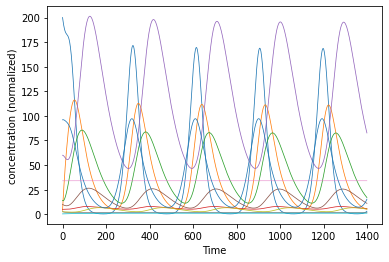

In [ ]:
plt.figure()
plt.plot(t, H, label="glucose intake", linewidth=0.75) #/175
plt.plot(t, S, label="stomach glucose", linewidth=0.75) #135
plt.plot(t, D, label="intestinal glucose", linewidth=0.75) #125
plt.plot(t, G, label="plasma glucose", linewidth=0.75) #/20
plt.plot(t, I, label="insulin", linewidth=0.75) #/500
plt.plot(t, W, label="incretin", linewidth=0.75)
plt.plot(t, E, label="glucagon", linewidth=0.5)
plt.plot(t, L, label="liver glucose", linewidth=0.75) #*20
plt.plot(t, M, label="muscle glucose", linewidth=0.75) #*7.5
#plt.plot(t, A, label="adipose glucose")
plt.plot(t, Y, label="leptin", linewidth=0.75)
plt.plot(t, Q/1.25, label="ghrelin", linewidth=0.75)
#plt.plot(t, II, label="interstitial insulin")
#plt.plot(t, IG, label="interstitial glucose") #/700
plt.xlabel("Time")
plt.ylabel("concentration (normalized)")
#plt.legend()

# Some lines have constants at the end that are commented out. 
# The constants are there to scale the graphs so everything appears on the same axis
# Constants that are commented out can be ignored or modified - they are only there for the purposes of visualization

In [1]:
# plt.figure()
# plt.plot(t, G, label="plasma glucose")
# plt.plot(t, I/55, label="insulin")
# plt.legend()

NameError: ignored